In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import polars as pl
from pathlib import Path
import torch

from scipy import signal
import ssm

from scipy.ndimage import gaussian_filter1d
from scipy.signal import butter, filtfilt
from scipy.signal import savgol_filter
import pandas as pd
import joblib

from transphorm.preprocessors.loaders import AADataLoader
from transphorm.analyzers import ARHMMAnalyzer
from dotenv import load_dotenv

load_dotenv()


False

In [22]:
model_path = Path("/projects/p31961/transphorm/models/arhmm/strange_cat_2082.joblib")
data_path = Path("/home/mds8301/data/gaby_data/full_recordings/dopamine_full_timeseries_array.pt")
model = joblib.load(model_path)
loader = AADataLoader(data_path, down_sample=True, low_pass=True, down_sample_factor=10)
loader.load_data()
loader.prepare_data()


In [23]:
analyzer = ARHMMAnalyzer(model= model,lls = None, loader= loader)
analyzer.compute_metrics()


/home/mds8301/.conda/envs/transphorm/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/mds8301/.conda/envs/transphorm/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
(loader.train[0].shape[0]/25)*5

25055.0

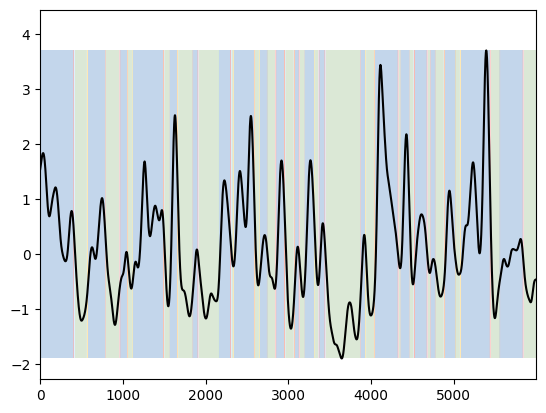

<Figure size 640x480 with 0 Axes>

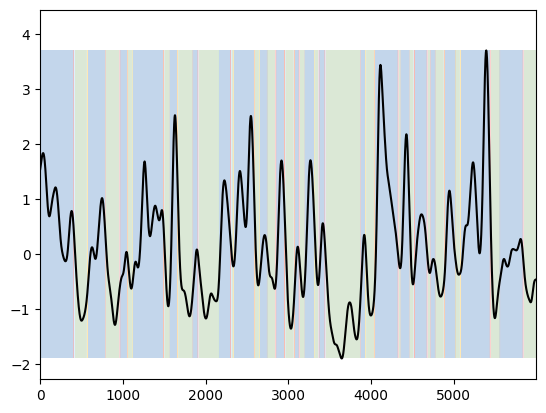

In [31]:
analyzer.plot_states()

In [8]:
def perplexity(normalized_ll):
    return np.exp(-normalized_ll)

train_perplexity = perplexity(mean_full_train_log_likelihood)
test_perplexity = perplexity(mean_test_log_likelihood)
test_perplexity
# Create a bar plot for train and test perplexity
# plt.figure(figsize=(10, 6))
# perplexities = [train_perplexity, test_perplexity]
# labels = ['Train', 'Test']
# colors = ['blue', 'orange']

# plt.bar(labels, perplexities, color=colors)
# plt.title('Train vs Test Perplexity')
# plt.ylabel('Perplexity')
# plt.ylim(0, max(perplexities) + max(perplexities)*0.1)

# for i, v in enumerate(perplexities):
#     plt.text(i, v, f'{v:.2f}', ha='center', va='bottom')

# plt.show()


# Calculate mean log probabilities for train and test data


NameError: name 'mean_full_train_log_likelihood' is not defined

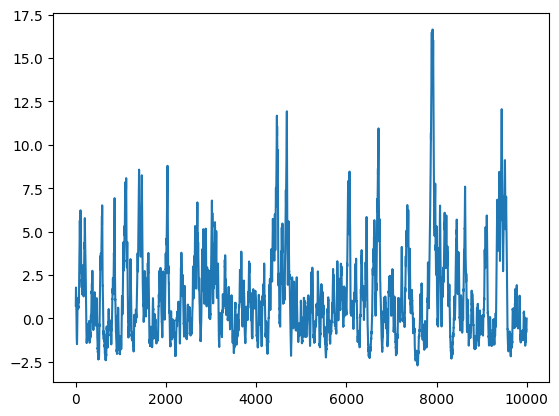

In [ ]:
# sample from model
samples = model.sample(10000)
# plt.plot(samples)
plt.plot(samples[1])

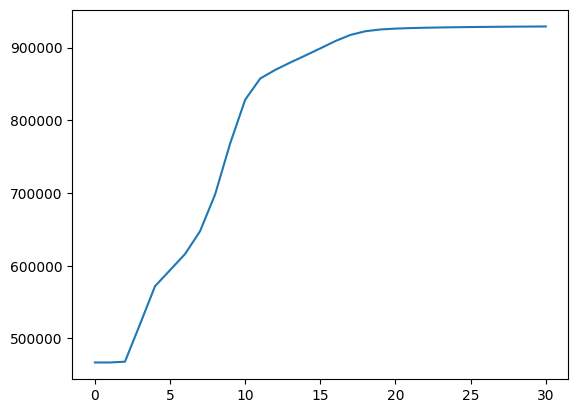

In [ ]:
plt.plot(lls)

In [ ]:
padded_state_0_segments = get_segments(state_0_motif)
padded_state_1_segments = get_segments(state_1_motif)
padded_state_2_segments = get_segments(state_2_motif)
# padded_state_3_segments = get_segments(state_3_motif)
# padded_state_4_segments = get_segments(state_4_motif)
# padded_state_5_segments = get_segments(state_5_motif)
# padded_state_6_segments = get_segments(state_6_motif)
# padded_state_7_segments = get_segments(state_7_motif)


fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 6), sharex=False)

plot_segments(padded_state_0_segments, ax[0,0], color='red')
plot_segments(padded_state_1_segments, ax[0,1], color='blue')
plot_segments(padded_state_2_segments, ax[0,2], color='green')
# plot_segments(padded_state_3_segments, ax[0,3], color='purple')
# plot_segments(padded_state_4_segments, ax[1,0], color='orange')
# plot_segments(padded_state_5_segments, ax[1,1], color='pink')
# plot_segments(padded_state_6_segments, ax[1,2], color='brown')
# plot_segments(padded_state_7_segments, ax[1,3], color='gray')

# plot_segments(padded_state_3_segments, ax[1,1], color='purple')
# plot_segments(padded_state_4_segments, ax[4])
# plot_segments(padded_state_5_segments, ax[5])

plt.tight_layout()